In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base
from feature_engineering.fe_xgb import generate_features

MODEL_NAME = "xgb_model"
PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-13 03:05:41.420396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 03:05:41.933323: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 03:05:43.624540: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_135


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
train, features = generate_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [05:05<00:00,  1.10s/it]


,anglez,anglez_diff_abs,anglez_diff_abs_clip5,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,same_count,total_seconds,...,enmo_std_rolling_median_100_shift_1000,anglez_diff_abs_clip5_std_rolling_median_100_shift_1000,same_count_rolling_median_100_shift_1000,enmo_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_rolling_square_mean_100_shift_1000,enmo_std_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_std_rolling_square_mean_100_shift_1000,same_count_rolling_square_mean_100_shift_1000,reduce_step,fold
27,-88.181526,0.078712,0.078712,-12.090329,0.029175,0.000292,0.030480,597.5,0.0,47397.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,659,3
28,-88.507393,0.106242,0.106242,-7.547437,0.029108,0.000433,0.051443,717.5,0.0,47517.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,683,3
29,-89.259064,0.057546,0.057546,-10.070161,0.029858,0.000262,0.104063,837.5,0.0,47637.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,707,3
30,-87.457848,0.147454,0.147454,-0.726222,0.029458,0.000533,0.095024,957.5,0.0,47757.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,731,3
31,-86.225922,0.169739,0.169739,-5.723403,0.030287,0.001758,0.092043,1077.5,0.0,47877.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,755,3


(471955, 1627)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_xgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG[MODEL_NAME]["xgboost"], 
        es_rounds=200,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_{event}_fold_{i}.model'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)


with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.54711
[100]	eval-rmse:1.13105
[200]	eval-rmse:1.02106
[300]	eval-rmse:0.99079
[400]	eval-rmse:0.98014
[500]	eval-rmse:0.97591
[600]	eval-rmse:0.97407
[700]	eval-rmse:0.97275
[800]	eval-rmse:0.97188
[900]	eval-rmse:0.97128
[1000]	eval-rmse:0.97076
[1100]	eval-rmse:0.97024
[1200]	eval-rmse:0.96975
[1300]	eval-rmse:0.96938
[1400]	eval-rmse:0.96907
[1500]	eval-rmse:0.96859
[1600]	eval-rmse:0.96839
[1700]	eval-rmse:0.96817
[1800]	eval-rmse:0.96801
[1900]	eval-rmse:0.96774
[2000]	eval-rmse:0.96752
[2100]	eval-rmse:0.96736
[2200]	eval-rmse:0.96729
[2300]	eval-rmse:0.96715
[2400]	eval-rmse:0.96702
[2500]	eval-rmse:0.96692
[2600]	eval-rmse:0.96686
[2700]	eval-rmse:0.96670
[2800]	eval-rmse:0.96659
[2900]	eval-rmse:0.96652
[3000]	eval-rmse:0.96647
[3100]	eval-rmse:0.96643
[3200]	eval-rmse:0.96637
[3300]	eval-rmse:0.96637
[3400]	eval-rmse:0.96628
[3500]	eval-rmse:0.96627
[3600]	eval-rmse:0.96617
[3700]	eval-rmse:0.96615
[3800]	eval-rmse:0.96612
[3900]	eval-rmse:0.96613

 20%|██        | 1/5 [04:02<16:08, 242.05s/it]

== fold 1 ==
[0]	eval-rmse:1.53679
[100]	eval-rmse:1.14202
[200]	eval-rmse:1.04132
[300]	eval-rmse:1.01304
[400]	eval-rmse:1.00198
[500]	eval-rmse:0.99607
[600]	eval-rmse:0.99305
[700]	eval-rmse:0.99113
[800]	eval-rmse:0.98958
[900]	eval-rmse:0.98843
[1000]	eval-rmse:0.98756
[1100]	eval-rmse:0.98652
[1200]	eval-rmse:0.98572
[1300]	eval-rmse:0.98504
[1400]	eval-rmse:0.98440
[1500]	eval-rmse:0.98375
[1600]	eval-rmse:0.98330
[1700]	eval-rmse:0.98286
[1800]	eval-rmse:0.98254
[1900]	eval-rmse:0.98227
[2000]	eval-rmse:0.98200
[2100]	eval-rmse:0.98164
[2200]	eval-rmse:0.98143
[2300]	eval-rmse:0.98128
[2400]	eval-rmse:0.98097
[2500]	eval-rmse:0.98072
[2600]	eval-rmse:0.98061
[2700]	eval-rmse:0.98044
[2800]	eval-rmse:0.98029
[2900]	eval-rmse:0.98007
[3000]	eval-rmse:0.97995
[3100]	eval-rmse:0.97981
[3200]	eval-rmse:0.97973
[3300]	eval-rmse:0.97960
[3400]	eval-rmse:0.97950
[3500]	eval-rmse:0.97939
[3600]	eval-rmse:0.97924
[3700]	eval-rmse:0.97914
[3800]	eval-rmse:0.97905
[3900]	eval-rmse:0.97906

 40%|████      | 2/5 [09:22<14:24, 288.30s/it]

== fold 2 ==
[0]	eval-rmse:1.59661
[100]	eval-rmse:1.21007
[200]	eval-rmse:1.11183
[300]	eval-rmse:1.08453
[400]	eval-rmse:1.07308
[500]	eval-rmse:1.06757
[600]	eval-rmse:1.06482
[700]	eval-rmse:1.06316
[800]	eval-rmse:1.06192
[900]	eval-rmse:1.06097
[1000]	eval-rmse:1.06019
[1100]	eval-rmse:1.05933
[1200]	eval-rmse:1.05865
[1300]	eval-rmse:1.05820
[1400]	eval-rmse:1.05769
[1500]	eval-rmse:1.05721
[1600]	eval-rmse:1.05685
[1700]	eval-rmse:1.05652
[1800]	eval-rmse:1.05608
[1900]	eval-rmse:1.05570
[2000]	eval-rmse:1.05544
[2100]	eval-rmse:1.05520
[2200]	eval-rmse:1.05501
[2300]	eval-rmse:1.05485
[2400]	eval-rmse:1.05467
[2500]	eval-rmse:1.05442
[2600]	eval-rmse:1.05424
[2700]	eval-rmse:1.05401
[2800]	eval-rmse:1.05386
[2900]	eval-rmse:1.05370
[3000]	eval-rmse:1.05359
[3100]	eval-rmse:1.05350
[3200]	eval-rmse:1.05343
[3300]	eval-rmse:1.05330
[3400]	eval-rmse:1.05318
[3500]	eval-rmse:1.05312
[3600]	eval-rmse:1.05293
[3700]	eval-rmse:1.05282
[3800]	eval-rmse:1.05279
[3900]	eval-rmse:1.05279

 60%|██████    | 3/5 [14:11<09:37, 288.73s/it]

== fold 3 ==
[0]	eval-rmse:1.57214
[100]	eval-rmse:1.15787
[200]	eval-rmse:1.05659
[300]	eval-rmse:1.02962
[400]	eval-rmse:1.02045
[500]	eval-rmse:1.01640
[600]	eval-rmse:1.01348
[700]	eval-rmse:1.01158
[800]	eval-rmse:1.01002
[900]	eval-rmse:1.00874
[1000]	eval-rmse:1.00755
[1100]	eval-rmse:1.00669
[1200]	eval-rmse:1.00586
[1300]	eval-rmse:1.00528
[1400]	eval-rmse:1.00482
[1500]	eval-rmse:1.00429
[1600]	eval-rmse:1.00387
[1700]	eval-rmse:1.00329
[1800]	eval-rmse:1.00287
[1900]	eval-rmse:1.00267
[2000]	eval-rmse:1.00238
[2100]	eval-rmse:1.00203
[2200]	eval-rmse:1.00182
[2300]	eval-rmse:1.00164
[2400]	eval-rmse:1.00136
[2500]	eval-rmse:1.00119
[2600]	eval-rmse:1.00096
[2700]	eval-rmse:1.00086
[2800]	eval-rmse:1.00069
[2900]	eval-rmse:1.00044
[3000]	eval-rmse:1.00028
[3100]	eval-rmse:1.00025
[3200]	eval-rmse:1.00024
[3300]	eval-rmse:1.00007
[3400]	eval-rmse:1.00002
[3500]	eval-rmse:0.99992
[3600]	eval-rmse:0.99980
[3700]	eval-rmse:0.99960
[3800]	eval-rmse:0.99955
[3900]	eval-rmse:0.99947

 80%|████████  | 4/5 [18:48<04:43, 283.79s/it]

== fold 4 ==
[0]	eval-rmse:1.59216
[100]	eval-rmse:1.18746
[200]	eval-rmse:1.08899
[300]	eval-rmse:1.06144
[400]	eval-rmse:1.05151
[500]	eval-rmse:1.04678
[600]	eval-rmse:1.04442
[700]	eval-rmse:1.04307
[800]	eval-rmse:1.04209
[900]	eval-rmse:1.04130
[1000]	eval-rmse:1.04065
[1100]	eval-rmse:1.04005
[1200]	eval-rmse:1.03958
[1300]	eval-rmse:1.03917
[1400]	eval-rmse:1.03879
[1500]	eval-rmse:1.03854
[1600]	eval-rmse:1.03822
[1700]	eval-rmse:1.03791
[1800]	eval-rmse:1.03767
[1900]	eval-rmse:1.03745
[2000]	eval-rmse:1.03729
[2100]	eval-rmse:1.03717
[2200]	eval-rmse:1.03713
[2300]	eval-rmse:1.03693
[2400]	eval-rmse:1.03683
[2500]	eval-rmse:1.03678
[2600]	eval-rmse:1.03668
[2700]	eval-rmse:1.03668
[2800]	eval-rmse:1.03671
[2900]	eval-rmse:1.03667
[3000]	eval-rmse:1.03658
[3100]	eval-rmse:1.03658
[3200]	eval-rmse:1.03658
[3300]	eval-rmse:1.03656
[3400]	eval-rmse:1.03654
[3500]	eval-rmse:1.03657
[3600]	eval-rmse:1.03650
[3700]	eval-rmse:1.03648
[3800]	eval-rmse:1.03657
[3900]	eval-rmse:1.03655

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.54706
[100]	eval-rmse:1.12160
[200]	eval-rmse:1.01056
[300]	eval-rmse:0.98017
[400]	eval-rmse:0.97059
[500]	eval-rmse:0.96654
[600]	eval-rmse:0.96482
[700]	eval-rmse:0.96384
[800]	eval-rmse:0.96314
[900]	eval-rmse:0.96247
[1000]	eval-rmse:0.96196
[1100]	eval-rmse:0.96163
[1200]	eval-rmse:0.96127
[1300]	eval-rmse:0.96093
[1400]	eval-rmse:0.96047
[1500]	eval-rmse:0.96025
[1600]	eval-rmse:0.96008
[1700]	eval-rmse:0.95984
[1800]	eval-rmse:0.95962
[1900]	eval-rmse:0.95944
[2000]	eval-rmse:0.95924
[2100]	eval-rmse:0.95909
[2200]	eval-rmse:0.95880
[2300]	eval-rmse:0.95879
[2400]	eval-rmse:0.95867
[2500]	eval-rmse:0.95849
[2600]	eval-rmse:0.95824
[2700]	eval-rmse:0.95814
[2800]	eval-rmse:0.95809
[2900]	eval-rmse:0.95797
[3000]	eval-rmse:0.95790
[3100]	eval-rmse:0.95788
[3200]	eval-rmse:0.95783
[3300]	eval-rmse:0.95770
[3400]	eval-rmse:0.95760
[3500]	eval-rmse:0.95757
[3600]	eval-rmse:0.95739
[3700]	eval-rmse:0.95733
[3800]	eval-rmse:0.95732
[3900]	eval-rmse:0.95721

 20%|██        | 1/5 [04:36<18:27, 276.82s/it]

== fold 1 ==
[0]	eval-rmse:1.53611
[100]	eval-rmse:1.11485
[200]	eval-rmse:1.00240
[300]	eval-rmse:0.96807
[400]	eval-rmse:0.95490
[500]	eval-rmse:0.94838
[600]	eval-rmse:0.94500
[700]	eval-rmse:0.94334
[800]	eval-rmse:0.94206
[900]	eval-rmse:0.94115
[1000]	eval-rmse:0.94038
[1100]	eval-rmse:0.93994
[1200]	eval-rmse:0.93943
[1300]	eval-rmse:0.93884
[1400]	eval-rmse:0.93839
[1500]	eval-rmse:0.93804
[1600]	eval-rmse:0.93767
[1700]	eval-rmse:0.93734
[1800]	eval-rmse:0.93710
[1900]	eval-rmse:0.93685
[2000]	eval-rmse:0.93660
[2100]	eval-rmse:0.93648
[2200]	eval-rmse:0.93629
[2300]	eval-rmse:0.93612
[2400]	eval-rmse:0.93592
[2500]	eval-rmse:0.93585
[2600]	eval-rmse:0.93574
[2700]	eval-rmse:0.93563
[2800]	eval-rmse:0.93563
[2900]	eval-rmse:0.93558
[3000]	eval-rmse:0.93547
[3100]	eval-rmse:0.93537
[3200]	eval-rmse:0.93531
[3300]	eval-rmse:0.93528
[3400]	eval-rmse:0.93523
[3500]	eval-rmse:0.93521
[3600]	eval-rmse:0.93518
[3700]	eval-rmse:0.93523
[3800]	eval-rmse:0.93524
[3825]	eval-rmse:0.93528

 40%|████      | 2/5 [08:38<12:48, 256.14s/it]

== fold 2 ==
[0]	eval-rmse:1.59709
[100]	eval-rmse:1.19789
[200]	eval-rmse:1.09242
[300]	eval-rmse:1.06134
[400]	eval-rmse:1.04979
[500]	eval-rmse:1.04482
[600]	eval-rmse:1.04226
[700]	eval-rmse:1.04052
[800]	eval-rmse:1.03936
[900]	eval-rmse:1.03847
[1000]	eval-rmse:1.03770
[1100]	eval-rmse:1.03720
[1200]	eval-rmse:1.03670
[1300]	eval-rmse:1.03620
[1400]	eval-rmse:1.03589
[1500]	eval-rmse:1.03558
[1600]	eval-rmse:1.03534
[1700]	eval-rmse:1.03505
[1800]	eval-rmse:1.03488
[1900]	eval-rmse:1.03460
[2000]	eval-rmse:1.03432
[2100]	eval-rmse:1.03420
[2200]	eval-rmse:1.03395
[2300]	eval-rmse:1.03383
[2400]	eval-rmse:1.03370
[2500]	eval-rmse:1.03367
[2600]	eval-rmse:1.03355
[2700]	eval-rmse:1.03351
[2800]	eval-rmse:1.03353
[2900]	eval-rmse:1.03345
[3000]	eval-rmse:1.03347
[3099]	eval-rmse:1.03349


 60%|██████    | 3/5 [11:46<07:29, 224.91s/it]

== fold 3 ==
[0]	eval-rmse:1.56419
[100]	eval-rmse:1.16275
[200]	eval-rmse:1.07029
[300]	eval-rmse:1.04814
[400]	eval-rmse:1.04177
[500]	eval-rmse:1.03975
[600]	eval-rmse:1.03855
[700]	eval-rmse:1.03775
[800]	eval-rmse:1.03696
[900]	eval-rmse:1.03623
[1000]	eval-rmse:1.03574
[1100]	eval-rmse:1.03524
[1200]	eval-rmse:1.03478
[1300]	eval-rmse:1.03451
[1400]	eval-rmse:1.03422
[1500]	eval-rmse:1.03395
[1600]	eval-rmse:1.03372
[1700]	eval-rmse:1.03356
[1800]	eval-rmse:1.03343
[1900]	eval-rmse:1.03329
[2000]	eval-rmse:1.03321
[2100]	eval-rmse:1.03311
[2200]	eval-rmse:1.03313
[2300]	eval-rmse:1.03306
[2400]	eval-rmse:1.03303
[2500]	eval-rmse:1.03300
[2600]	eval-rmse:1.03302
[2700]	eval-rmse:1.03299
[2716]	eval-rmse:1.03299


 80%|████████  | 4/5 [14:40<03:24, 204.75s/it]

== fold 4 ==
[0]	eval-rmse:1.58749
[100]	eval-rmse:1.19128
[200]	eval-rmse:1.09457
[300]	eval-rmse:1.06928
[400]	eval-rmse:1.06065
[500]	eval-rmse:1.05635
[600]	eval-rmse:1.05400
[700]	eval-rmse:1.05261
[800]	eval-rmse:1.05122
[900]	eval-rmse:1.05032
[1000]	eval-rmse:1.04942
[1100]	eval-rmse:1.04883
[1200]	eval-rmse:1.04815
[1300]	eval-rmse:1.04759
[1400]	eval-rmse:1.04702
[1500]	eval-rmse:1.04654
[1600]	eval-rmse:1.04610
[1700]	eval-rmse:1.04574
[1800]	eval-rmse:1.04552
[1900]	eval-rmse:1.04525
[2000]	eval-rmse:1.04501
[2100]	eval-rmse:1.04482
[2200]	eval-rmse:1.04454
[2300]	eval-rmse:1.04434
[2400]	eval-rmse:1.04415
[2500]	eval-rmse:1.04400
[2600]	eval-rmse:1.04392
[2700]	eval-rmse:1.04384
[2800]	eval-rmse:1.04366
[2900]	eval-rmse:1.04359
[3000]	eval-rmse:1.04355
[3100]	eval-rmse:1.04342
[3200]	eval-rmse:1.04338
[3300]	eval-rmse:1.04336
[3400]	eval-rmse:1.04337
[3432]	eval-rmse:1.04336


100%|██████████| 5/5 [18:06<00:00, 217.35s/it]


## Dynamic-Range NMS

<AxesSubplot: >

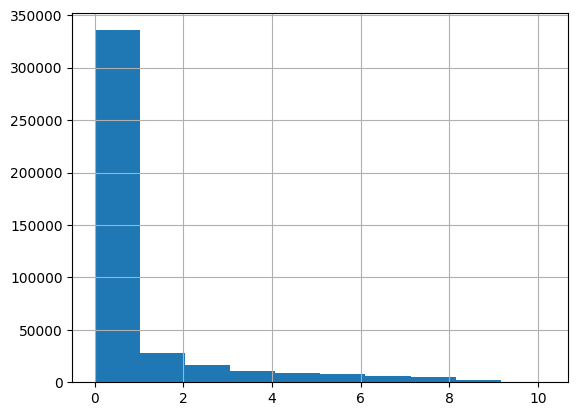

In [4]:
train = train[train["score"] > 0.005]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:05<00:00, 50.71it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7855


event   tolerance
onset   12           0.263697
        36           0.692388
        60           0.792800
        90           0.833408
        120          0.849709
        150          0.863877
        180          0.871754
        240          0.885818
        300          0.891709
        360          0.897191
wakeup  12           0.204799
        36           0.710520
        60           0.797921
        90           0.836316
        120          0.855352
        150          0.869634
        180          0.879548
        240          0.894558
        300          0.903936
        360          0.914613
dtype: float64